# Mercedes F1 Performance Analysis: Identifying Key Success Factors (2014 Onwards)
####  Summary
This report presents a comprehensive analysis of Mercedes' Formula 1 performance from 2014 onwards, with comparisons to McLaren and other top teams. Using advanced data analytics and machine learning techniques, we've identified the key factors that correlate with Mercedes' race wins, focusing specifically on pole gap, lap times, race location, and pit stop strategies.

Our analysis reveals that Mercedes' dominance during this period can be attributed to several key factors:

1. Superior qualifying performance with minimal pole gaps

2. Consistent race pace with competitive lap times

3. Strong performance at specific circuit types

4. Efficient pit stop strategies

This report will provide insights into each of these factors and offers recommendations for maintaining competitive advantage in future seasons.

### Data Preparation and Cleaning

To prepare the datasets for analysis and modelling for Formula 1 race performance, a comprehensive data preparation pipeline was developed, integrating multiple Snowflake tables, handling missing and inconsistent data, and engineering relevant features. This section outlines the key steps taken.

##### 1. Data ingestion and Integration

Data was extracted from six core snowflake tables:
- CIRCUITS
- DRIVERS
- RACES
- CONSTRUCTORS
- STATUS
- RESULTS

These tables were copied over to our event space, and can be find within the csv files directory, as well as on snowflake under `EVENT.DATATHON_2025_TEAM_ETA` schema.

Each table was imported using the `query_to_df()` function, returning Pandas Dataframes. MErges were performed ons shared keys such as `RACEDID`, `DRIVERID`, and `CONSTRUCTORID`. Column renaming was applied for clarity, e.g. `NAME` to `RACE_NAME` or `CONSTRUCTOR_NAME`.

In [3]:
import snowflake.connector
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv as dot
from sqlalchemy import create_engine
# from dotenv import load_dotenv

DATABASE_SCHEMA = 'EVENT.DATATHON_2025_TEAM_ETA'

def get_snowflake_connection():
    '''
    Create a connection to Snowflake using credentials from .env file
    '''
    # Load environment variables
    dot.load_dotenv()
    
    # Get connection parameters from environment variables
    conn = snowflake.connector.connect(
        account=os.getenv('SNOWFLAKE_ACCOUNT'),
        user=os.getenv('SNOWFLAKE_USER'),
        password=os.getenv('SNOWFLAKE_PASSWORD'),
        role=os.getenv('SNOWFLAKE_ROLE'),
        warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
        database=os.getenv('SNOWFLAKE_DATABASE'),
        schema=os.getenv('SNOWFLAKE_SCHEMA')
    )
    
    return conn

def query_to_df(query):
    '''
    Execute a query and return the results as a pandas DataFrame
    '''
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    cursor.execute(query)

    # Get column names
    columns = [col[0] for col in cursor.description]

    # Fetch all rows and convert to list of dictionaries
    results = [dict(zip(columns, row)) for row in cursor.fetchall()]

    cursor.close()
    conn.close()

    return pd.DataFrame(results)

def upload_csv_to_snowflake(dataframe, table_name):
    
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    
    engine = create_engine(
        f'snowflake://{conn.user}:{os.getenv('SNOWFLAKE_PASSWORD')}@{conn.account}/{conn.database}/{conn.schema}?warehouse={conn.warehouse}'
    )
    dataframe.to_sql(
        name=table_name,
        con=engine,
        schema=conn.schema,
        if_exists='replace',
        index=False,
        method='multi'
    )
    
    # Get row count
    cursor = conn.cursor()
    cursor.execute(f'SELECT COUNT(*) FROM {conn.database}.{conn.schema}.{table_name}')
    row_count = cursor.fetchone()[0]
    cursor.close()
    conn.close()
    
    return row_count

In [ ]:
# Create a master dataset from circuits, drivers, races, constructors, status, results
status = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.STATUS')
circuits = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.CIRCUITS')
drivers = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.DRIVERS')

races = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.RACES')
races = races.rename(columns={'NAME': 'RACE_NAME'})

constructors = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.CONSTRUCTORS')
constructors = constructors.rename(columns={'NAME': 'CONSTRUCTOR_NAME'})
constructors = constructors.rename(columns={'NATIONALITY': 'CONSTRUCTOR_NATIONALITY'})

results = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.RESULTS')


main_df = results.merge(races, on='RACEID', suffixes=('', '_race')).merge(
    drivers, 
    on='DRIVERID', 
    suffixes=('', '_DRIVER')
).merge(
    constructors, 
    on='CONSTRUCTORID', 
    suffixes=('', '_CONSTRUCTOR')
).merge(
    status, 
    on='STATUSID', 
    suffixes=('', '_STATUS')
).merge(
    circuits,
    on='CIRCUITID',
    suffixes=('', 'CIRCUIT')
)

print(main_df.shape)
print(main_df.columns)
print(main_df.info())


Number of duplicate 0
(26759, 51)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'NUMBER', 'GRID',
       'POSITION', 'POSITIONTEXT', 'POSITIONORDER', 'POINTS', 'LAPS', 'TIME',
       'MILLISECONDS', 'FASTESTLAP', 'RANK', 'FASTESTLAPTIME',
       'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND', 'CIRCUITID',
       'RACE_NAME', 'DATE', 'TIME_race', 'FP1_DATE', 'FP1_TIME', 'FP2_DATE',
       'FP2_TIME', 'FP3_DATE', 'FP3_TIME', 'QUALI_DATE', 'QUALI_TIME',
       'SPRINT_DATE', 'SPRINT_TIME', 'FULL_NAME', 'DOB', 'NATIONALITY', 'WINS',
       'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY', 'STATUS', 'NAME',
       'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT', 'ALTITUDE_CATEGORY',
       'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS', 'ESTIMATED_RACE_DISTANCE_KM'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      ----------

##### 2. Initial Data Filtering and Duplication.

The dataset was filtered to only include races from 2014 onwards, reducing dimensionality and focusing on <WHAT WAS THE BIG CHANGE>, to reduce historical rows. Duplicate rows were checked, but none were found

In [ ]:
# Check if there are any duplicates
print(f'Number of duplicate {main_df.duplicated().sum()}')

# Filter from 2014 to now
filter_df = main_df[main_df['YEAR'] >=2014].copy()

print(filter_df.shape)
print(filter_df.columns)
print(filter_df.info())

(4626, 51)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'NUMBER', 'GRID',
       'POSITION', 'POSITIONTEXT', 'POSITIONORDER', 'POINTS', 'LAPS', 'TIME',
       'MILLISECONDS', 'FASTESTLAP', 'RANK', 'FASTESTLAPTIME',
       'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND', 'CIRCUITID',
       'RACE_NAME', 'DATE', 'TIME_race', 'FP1_DATE', 'FP1_TIME', 'FP2_DATE',
       'FP2_TIME', 'FP3_DATE', 'FP3_TIME', 'QUALI_DATE', 'QUALI_TIME',
       'SPRINT_DATE', 'SPRINT_TIME', 'FULL_NAME', 'DOB', 'NATIONALITY', 'WINS',
       'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY', 'STATUS', 'NAME',
       'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT', 'ALTITUDE_CATEGORY',
       'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS', 'ESTIMATED_RACE_DISTANCE_KM'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 4626 entries, 22127 to 26758
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RESULT

##### 2. Missing Values Analysis

A custom function was implemented to compute and print the total and percentage of missing values per column. This was then visualised using a Seaborn heatmap. This step revealed serveral non-critical columns with high missing rates (e.g. sprint and free practice related columns), guiding further cleansing decisions.

                 Missing Values  Percent Missing
SPRINT_TIME                4326        93.514916
SPRINT_DATE                4266        92.217899
FP3_TIME                   3567        77.107652
FP1_TIME                   3267        70.622568
FP2_TIME                   3267        70.622568
QUALI_TIME                 3267        70.622568
FP3_DATE                   3187        68.893212
FP1_DATE                   2827        61.111111
FP2_DATE                   2827        61.111111
QUALI_DATE                 2827        61.111111
MILLISECONDS               2219        47.968007
TIME                       2219        47.968007
POSITION                    721        15.585819
FASTESTLAPTIME              217         4.690878
FASTESTLAP                  217         4.690878
FASTESTLAPSPEED             217         4.690878


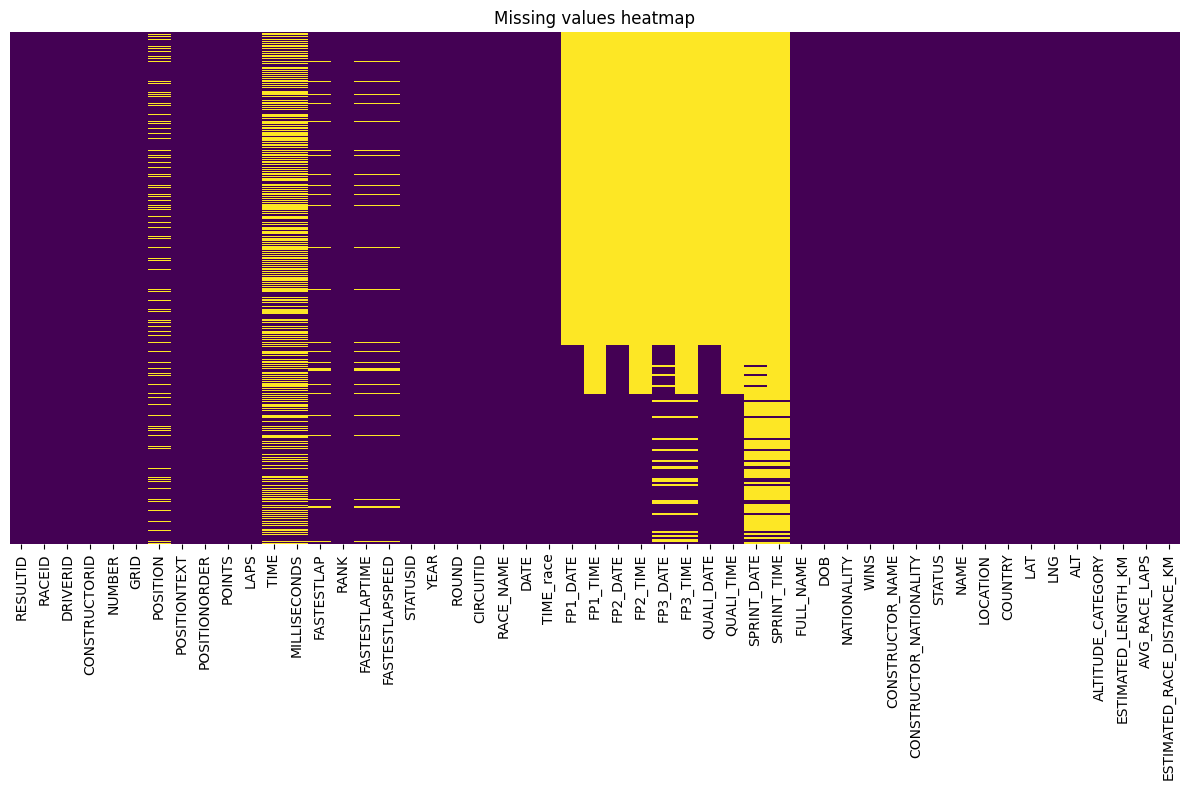

In [8]:
def missing_vals_analysis(df):
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percent Missing': missing_percent
    })
    print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percent Missing', ascending=False))
    plt.figure(figsize=(12,8))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing values heatmap')
    plt.tight_layout()
    plt.show()
    plt.savefig('{df}_missing_values_heatmap.png')
    plt.close()

missing_vals_analysis(filter_df)

#### 4. Column Pruning

From the missing values analysis, we were able to discover columns irrelevant for downstream modelling so they were droped. This included session-specific dates and times, and redundant race metadata.

An example of the redundant race metadata is POSITION, POSITIONTEXT, POSTITIONORDER. Position was missing 15% of it's values, and of the values that were there they were the same as POSITION TEXT AND POSITIONORDER. Further review of these two columns, showed that the top 8 values were the same, and then the orders changed to either R or the position up to 20. We decided to use POSITIONORDER, as all values were populated with the same data type.

                 Missing Values  Percent Missing
MILLISECONDS               2219        47.968007
FASTESTLAP                  217         4.690878
FASTESTLAPTIME              217         4.690878
FASTESTLAPSPEED             217         4.690878


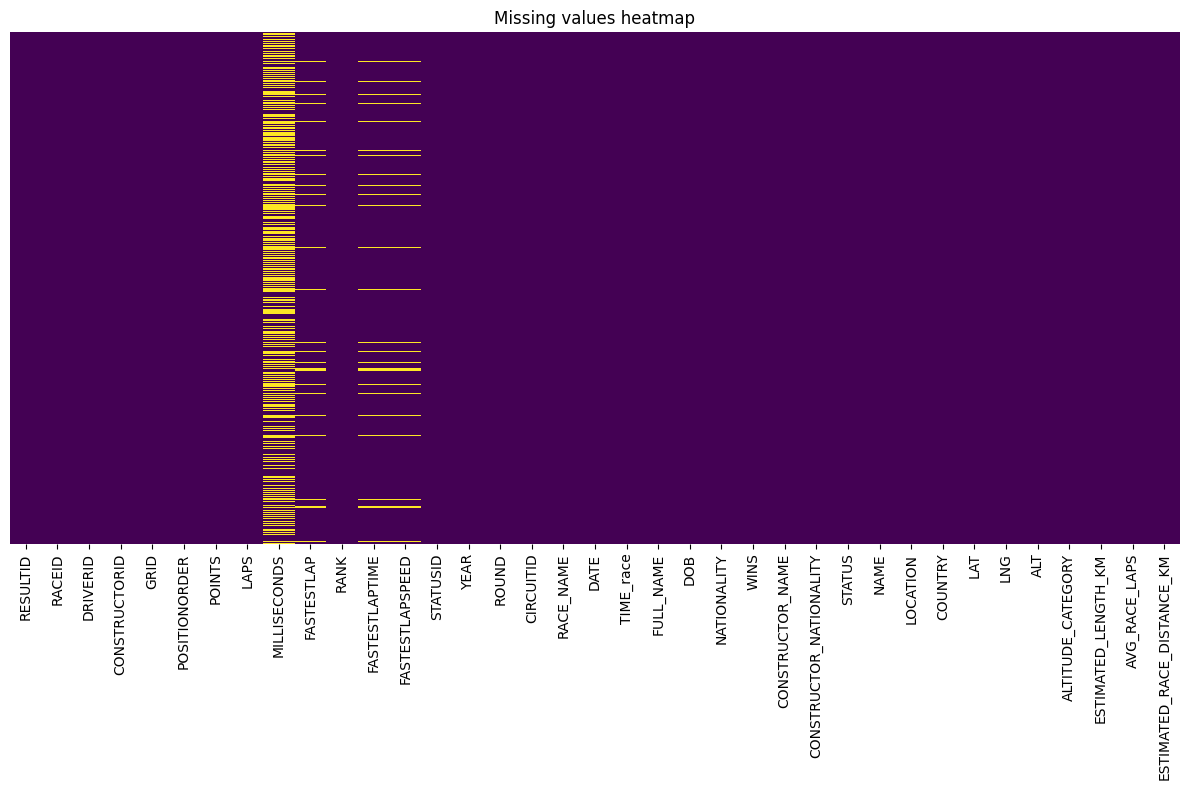

In [9]:
columns_to_drop = [
    'POSITION', 'POSITIONTEXT', 'TIME', 'NUMBER', 'SPRINT_TIME', 'SPRINT_DATE',
    'FP3_TIME', 'FP1_TIME', 'FP2_TIME', 'QUALI_TIME','FP1_DATE', 'FP3_DATE', 'FP2_DATE',
    'QUALI_DATE', 'TIME'
]

filter_df.drop(columns=columns_to_drop, inplace=True)

missing_vals_analysis(filter_df)

#### 5. Data Type Standardisation

Several numeric and date fields were explicitly cast to appropriate types. Parsing errors were handled using coerce, ensuring robustness against malformed data.

                 Missing Values  Percent Missing
MILLISECONDS                797        17.228707
FASTESTLAPTIME              217         4.690878
FASTESTLAP                  208         4.496325
FASTESTLAPSPEED             208         4.496325


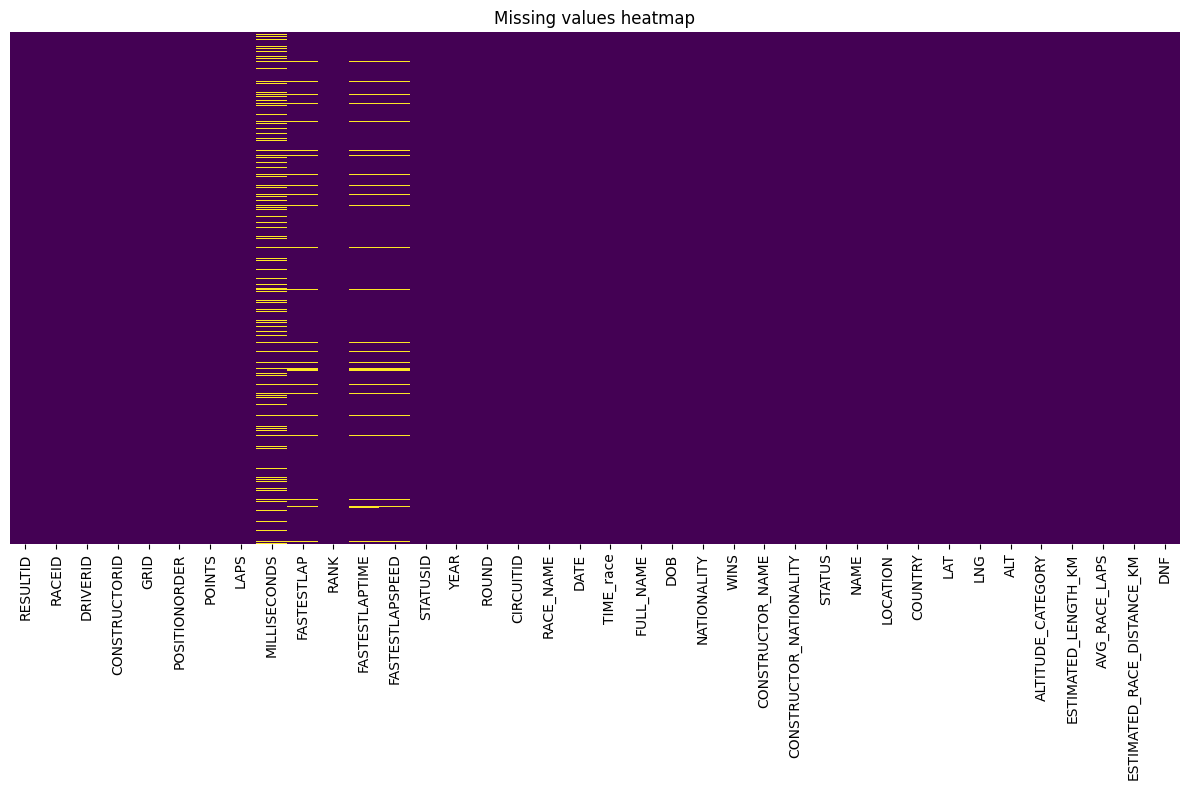

In [10]:
# Fixing incorrect dtypes
filter_df['POINTS'] = pd.to_numeric(filter_df['POINTS'], errors='coerce')
filter_df['FASTESTLAPSPEED'] = pd.to_numeric(filter_df['FASTESTLAPSPEED'], errors='coerce')
filter_df['LAT'] = pd.to_numeric(filter_df['LAT'], errors='coerce')
filter_df['LNG'] = pd.to_numeric(filter_df['LNG'], errors='coerce')

filter_df['DATE'] = pd.to_datetime(filter_df['DATE'], errors='coerce')
filter_df['DOB'] = pd.to_datetime(filter_df['DOB'], errors='coerce')

def race_finished(status):
    return status == 'Finished' or status.strip().startswith('+')

filter_df['DNF'] = filter_df.apply(
    lambda row: pd.isnull(row['MILLISECONDS']) and race_finished(row['STATUS']),
    axis=1)
# convert to int for modelling, 1 is didn't finish and 0 if finishd
filter_df['DNF'] = filter_df['DNF'].astype(int)

filter_df['MILLISECONDS'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['MILLISECONDS']) and row['DNF'] == 1 else row['MILLISECONDS'], 
    axis=1
)
filter_df['FASTESTLAP'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['FASTESTLAP']) and row['DNF'] == 1 else row['FASTESTLAP'], 
    axis=1
)
filter_df['FASTESTLAPSPEED'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['FASTESTLAPSPEED']) and row['DNF'] == 1 else row['FASTESTLAPSPEED'], 
    axis=1
)
missing_vals_analysis(filter_df)

Number of rows with null FASTESTLAP: 208
   RACEID           RACE_NAME  YEAR  DRIVER_COUNT
0    1063  Belgian Grand Prix  2021            20
                 Missing Values  Percent Missing
FASTESTLAPTIME              217         4.690878
FASTESTLAP                  208         4.496325
FASTESTLAPSPEED             208         4.496325


C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_32332\3389799057.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  races_with_all_null_fastlap = filter_df.groupby(['RACEID', 'RACE_NAME', 'YEAR']).apply(


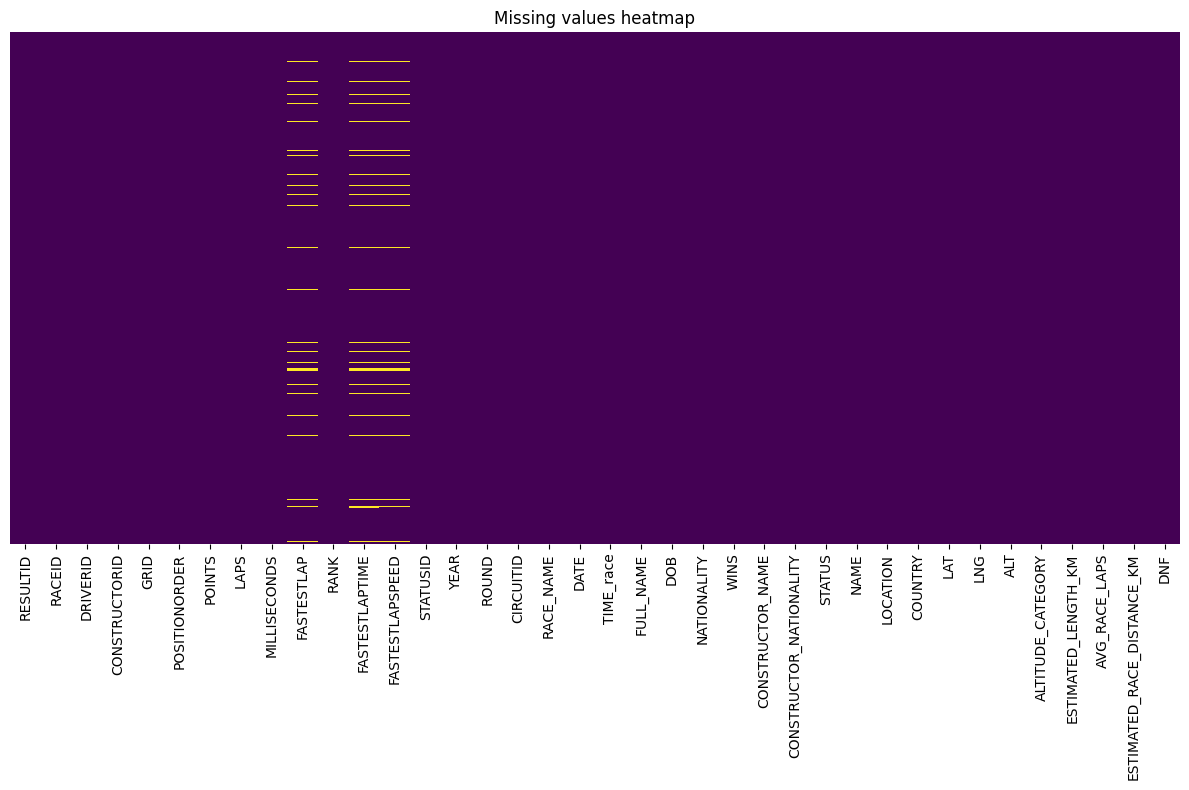

In [11]:
print(f'Number of rows with null FASTESTLAP: {len( filter_df[filter_df['FASTESTLAP'].isnull()])}')


races_with_all_null_fastlap = filter_df.groupby(['RACEID', 'RACE_NAME', 'YEAR']).apply(
    lambda group: group['FASTESTLAP'].isnull().all()
).reset_index()

# Rename the result column
races_with_all_null_fastlap = races_with_all_null_fastlap.rename(columns={0: 'ALL_NULL_FASTLAP'})

# Filter to only show races where all drivers have null FASTESTLAP
races_with_all_null_fastlap = races_with_all_null_fastlap[races_with_all_null_fastlap['ALL_NULL_FASTLAP']]

# Check how many drivers were in each of these races
race_counts = filter_df[filter_df['RACEID'].isin(races_with_all_null_fastlap['RACEID'])].groupby(
    ['RACEID', 'RACE_NAME', 'YEAR']
).size().reset_index(name='DRIVER_COUNT')

print(race_counts.sort_values('YEAR'))

# for each race, grab posorder as 1 and check status is finished, grab the number of laps completed. 
# if milliseconds is null fill with 0

winners = filter_df[(filter_df['POSITIONORDER'] == 1) &( filter_df['STATUSID'] == 1)].copy()
race_winner_laps = winners[['RACEID', 'LAPS']].set_index('RACEID')['LAPS'].to_dict()

def determine_dnf(row):
    winner_laps = race_winner_laps.get(row['RACEID'])

    if pd.isnull(row['MILLISECONDS']) and row['LAPS'] < winner_laps:
        return True
    elif row['STATUS'] != 'Finished' and not str(row['STATUS']).strip().startswith('+'):
        return True
    else:
        return False

# Apply the function to create/update DNF column
filter_df['DNF'] = filter_df.apply(determine_dnf, axis=1)

# Step 3: Set milliseconds to 0 for DNF races
filter_df.loc[filter_df['DNF'] == 1, 'MILLISECONDS'] = 0

missing_vals_analysis(filter_df)

In [12]:
filter_df = filter_df[(filter_df['GRID'] <= 30) & (filter_df['LAPS'] > 0)]

print(filter_df.shape)
print(filter_df.columns)
print(filter_df.info())

(4486, 38)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'GRID',
       'POSITIONORDER', 'POINTS', 'LAPS', 'MILLISECONDS', 'FASTESTLAP', 'RANK',
       'FASTESTLAPTIME', 'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND',
       'CIRCUITID', 'RACE_NAME', 'DATE', 'TIME_race', 'FULL_NAME', 'DOB',
       'NATIONALITY', 'WINS', 'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY',
       'STATUS', 'NAME', 'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT',
       'ALTITUDE_CATEGORY', 'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS',
       'ESTIMATED_RACE_DISTANCE_KM', 'DNF'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 4486 entries, 22127 to 26757
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   RESULTID                    4486 non-null   int64         
 1   RACEID                      4486 non-null   int64         
 2   DRIVERID                    4486 non-null   int

In [ ]:
upload_csv_to_snowflake(filter_df, 'CIRCUIT_CONSTRUCTOR_DRIVER_RACE_STATUS')

#### Feature Engineering

In [ ]:
Create pole gap, position change, lap time difference from fastest gap
Altitude categories -> sea level, low, med, high (change what emily did with jsut low and high)
Indicators for win, podium

### EDA

#### Team Performance Overview

In [ ]:
Get the top teams for comparisons, include mercedes and mclaren if they aren't in -> top 5->10 teams

Get win rate, podium rate, dnf rate, average points, grid to finish

visualise team performances by year 


#### Pole Gap Analysis

In [ ]:
pole gap analysis for top teams

visualise gap distribution
relationship between pole gap and race win %

#### Lap Time Analysis

In [ ]:
lap time analysis for top teams
visualise distribution
relationship between fastest lap and race win

#### Circuit Location Analysis

In [ ]:
performance by circuit for Mercedes vs McLaren 0? TODO could be a good idea to just focus on these two teams

for each team:
    top 10 circuits
performance by altitude category

#### Tire Strategy/ Pit Stop Analysis

In [ ]:
#estimate pitstops
analyse mercedes + mclaren performance by estimated pit stop
visualise


### Factor Analysis using Machine Learning

#### Prepare Data for Modelling

In [ ]:
focus on mercedes and McLaren
define features and target -> pole gap, grid, fastest lap sec, fastest lap speed, circuit name, country, alt category
handle missing vals
categorical variables encode -> circuit name, country, alt category
split data etc. etc.

#### Model 1 - Random Forest Model

#### Model 2 - Logistic Regression for Interpretability

#### Model 3 - Gradient Boosting Classifier

#### Model 4 - Support Vector Machine

#### Model 5 - Neural Network

### Model Comparison

#### 3. Circuit Location Analysis

# Key Findings and Insights

#### 1. Pole Gap Analysis

####  2. Lap Time Analysis

####  3. Circuit Location Analysis

####  4. Machine Learning Factor Analysis

# Recommendations and Conclusion